# SHAP Values

Veremos brevemente un modelo de interpretabilidad para modelos complejos de machine learning como es un LGBM.

El uso de **python** para esta exploración se debe a la madurez encontrada en las librerías en mi búsqueda.

Empezamos con la carga de los módulos necesarios:

In [2]:
import pandas as pd
import numpy as np

import lightgbm as lgb

Cargamos con **pandas** lentamente el dataset. Sólo vamos a trabajar con el primer conjunto de datos que es el más pequeño. Con un poco más de paciencia podrá usar los conjuntos más pesados. 

In [3]:
df_train = pd.read_csv("./../../../datasets/exp_4_TRAINING_STRATEGY_miranda_dataset_training.csv.gz")



In [20]:
Xtrain = df_train[df_train["foto_mes"] == 202105 ]
ytrain = Xtrain["clase_ternaria"].map(lambda x: 0 if x == "CONTINUA" else 1)

Separamos también todos los casos de **BAJAS+1** y **BAJAS+2**

In [4]:
Xbajas = df_train.query("clase_ternaria != 'CONTINUA'")

In [14]:
Xbajas.loc[Xbajas['foto_mes']==202006].clase_ternaria.head()

Series([], Name: clase_ternaria, dtype: object)

In [15]:
Xbajas.groupby('foto_mes').count()

,numero_de_cliente,active_quarter,cliente_vip,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,mcomisiones,mactivos_margen,mpasivos_margen,...,vmr_mpagado_tend6,vmr_mpagospesos_tend6,vmr_mpagosdolares_tend6,vmr_mconsumototal_tend6,vmr_mpagominimo_tend6,azar_sampling,azar_under,fold_train,fold_validate,fold_test
foto_mes,,,,,,,,,,,,,,,,,,,,,
202007,234,234,234,234,234,234,234,234,234,234,...,233,233,233,233,233,234,234,234,234,234
202008,187,187,187,187,187,187,187,187,187,187,...,185,185,185,185,185,187,187,187,187,187
202009,169,169,169,169,169,169,169,169,169,169,...,168,168,168,168,168,169,169,169,169,169
202010,221,221,221,221,221,221,221,221,221,221,...,221,221,221,221,221,221,221,221,221,221
202011,229,229,229,229,229,229,229,229,229,229,...,228,228,228,228,228,229,229,229,229,229
202012,276,276,276,276,276,276,276,276,276,276,...,273,273,273,273,273,276,276,276,276,276
202101,328,328,328,328,328,328,328,328,328,328,...,325,325,325,325,325,328,328,328,328,328
202102,364,364,364,364,364,364,364,364,364,364,...,363,363,363,363,363,364,364,364,364,364
202103,433,433,433,433,433,433,433,433,433,433,...,432,432,432,432,432,433,433,433,433,433


Y nos deshacemos del target y limpiamos un poco la memoria.

In [21]:
Xtrain = Xtrain.drop("clase_ternaria", axis=1)
Xbajas = Xbajas.drop("clase_ternaria", axis=1)

del(df_train)

Hacemos un modelo **LGBM**

In [22]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(Xtrain, ytrain)

# specify your configurations as a dict
params = {
    'objective': 'binary',
    'learning_rate': 0.05,
    'verbose': 2,
    'max_bin': 15,
    'min_data_in_leaf': 4000,
    'verbose': 0,
}

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=100)


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.447147 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Y miramos su importancia de variables

In [23]:
lgbm_importancia = pd.DataFrame({'Features': gbm.feature_name(),
                        'Importances': gbm.feature_importance()})
lgbm_importancia.sort_values(by='Importances', inplace=True, ascending=False)
lgbm_importancia


,Features,Importances
152,ctrx_quarter_normalizado,87
21,mcuentas_saldo,68
10,mpasivos_margen,60
7,mrentabilidad_annual,52
96,chomebanking_transacciones,49
...,...,...
207,tcuentas_tend6,0
208,ccuenta_corriente_tend6,0
209,mcuenta_corriente_adicional_tend6,0
211,ccaja_ahorro_tend6,0


Ahora avanzamos aplicando un modelo de interpretabilidad sobre el modelo anterior.

In [24]:
import shap

/home/user/.local/share/virtualenvs/labo-a041pJnc/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [25]:
explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(Xbajas)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Consolidamos los valores de **SHAP** para cada variable y para cada **BAJA+\***

In [26]:
shap_bajas = pd.DataFrame(shap_values[0], columns = Xbajas.columns)
shap_bajas

,numero_de_cliente,foto_mes,active_quarter,cliente_vip,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,mcomisiones,mactivos_margen,...,vmr_mpagado_tend6,vmr_mpagospesos_tend6,vmr_mpagosdolares_tend6,vmr_mconsumototal_tend6,vmr_mpagominimo_tend6,azar_sampling,azar_under,fold_train,fold_validate,fold_test
0,0.001894,0.0,0.0,0.0,0.002702,0.000739,-0.001216,0.066554,0.002911,-0.040508,...,-0.006346,-0.040002,0.0,0.0,-0.005989,0.0,0.0,0.0,0.0,0.0
1,0.001748,0.0,0.0,0.0,0.004140,0.004341,-0.000702,0.074607,-0.011429,-0.050537,...,-0.006729,-0.018247,0.0,0.0,0.000901,0.0,0.0,0.0,0.0,0.0
2,0.000526,0.0,0.0,0.0,0.007705,0.001853,0.000023,-0.012697,-0.016536,-0.080263,...,-0.006350,-0.040723,0.0,0.0,-0.000654,0.0,0.0,0.0,0.0,0.0
3,-0.000297,0.0,0.0,0.0,0.017547,0.008675,-0.002316,-0.085299,-0.010150,-0.102905,...,-0.006172,-0.042089,0.0,0.0,-0.001154,0.0,0.0,0.0,0.0,0.0
4,0.007506,0.0,0.0,0.0,0.023698,0.012575,0.004420,-0.071976,-0.015438,0.046957,...,-0.006350,-0.016339,0.0,0.0,0.000781,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6552,-0.014580,0.0,0.0,0.0,0.001277,0.001933,0.005648,-0.078348,-0.025319,0.075987,...,-0.005581,0.053823,0.0,0.0,0.000781,0.0,0.0,0.0,0.0,0.0
6553,-0.026731,0.0,0.0,0.0,0.035244,-0.001834,0.005420,-0.085975,-0.020512,-0.061029,...,-0.005285,-0.041479,0.0,0.0,-0.000784,0.0,0.0,0.0,0.0,0.0
6554,-0.024429,0.0,0.0,0.0,-0.065266,-0.004331,0.007094,-0.109943,-0.025860,-0.129644,...,-0.004740,-0.042455,0.0,0.0,0.000800,0.0,0.0,0.0,0.0,0.0
6555,-0.033486,0.0,0.0,0.0,0.041152,-0.003611,0.003250,-0.102234,-0.018663,-0.062826,...,-0.006660,-0.024268,0.0,0.0,0.000781,0.0,0.0,0.0,0.0,0.0


Y consolidamos sus importancias

In [27]:
shap_importancias = shap_bajas.mean().abs().sort_values(ascending=False)
shap_importancias

ctrx_quarter_normalizado             0.792997
cpayroll_trx                         0.465808
mpayroll                             0.409624
mcuentas_saldo                       0.194859
mtarjeta_visa_consumo                0.139693
                                       ...   
tcuentas_tend6                       0.000000
ccuenta_corriente_tend6              0.000000
mcuenta_corriente_adicional_tend6    0.000000
ccaja_ahorro_tend6                   0.000000
fold_test                            0.000000
Length: 397, dtype: float64

La librería nos da útiles herramientas para vizualizar la info anterior

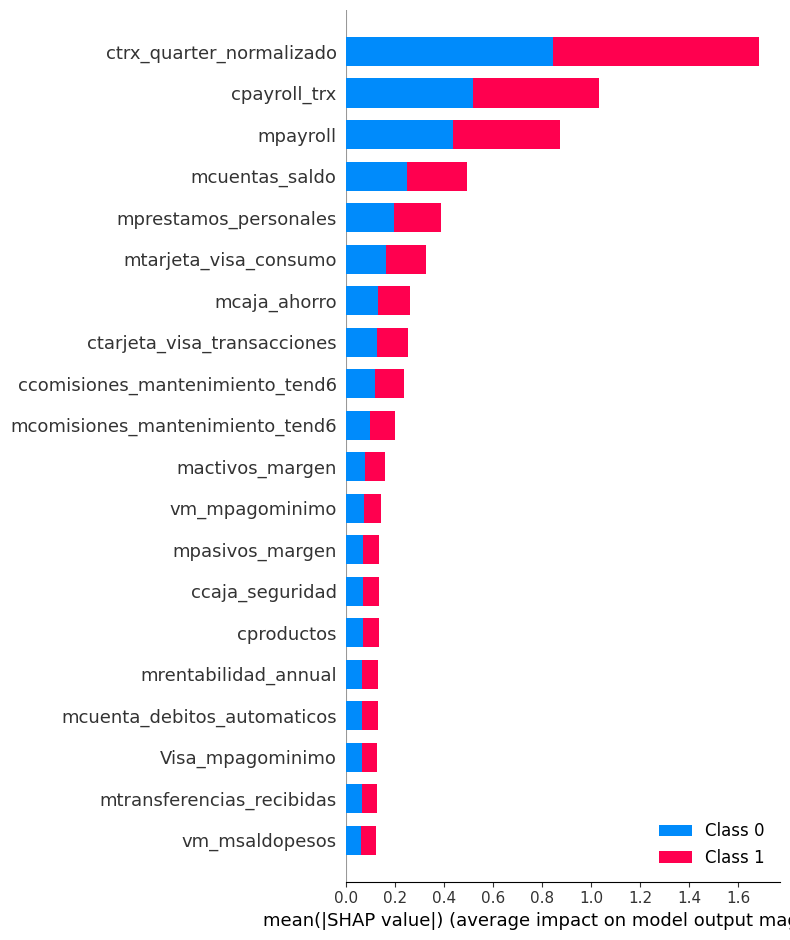

In [28]:
shap.summary_plot(shap_values, Xbajas)


Y ahora debemos empezar a jugar para entender como estan asociadas las variables a los **shap values**

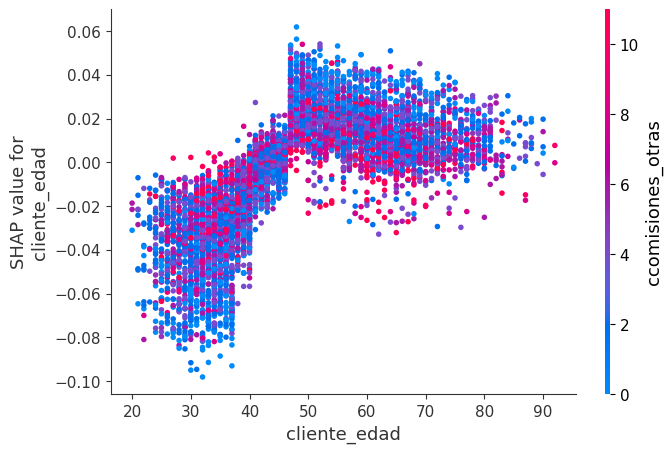

In [29]:
shap.dependence_plot("cliente_edad", shap_values[0], Xbajas)

In [37]:
shap_values[0]

array([[ 0.00189429,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.00174799,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.00052595,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.02442945,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.03348594,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.03613745,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

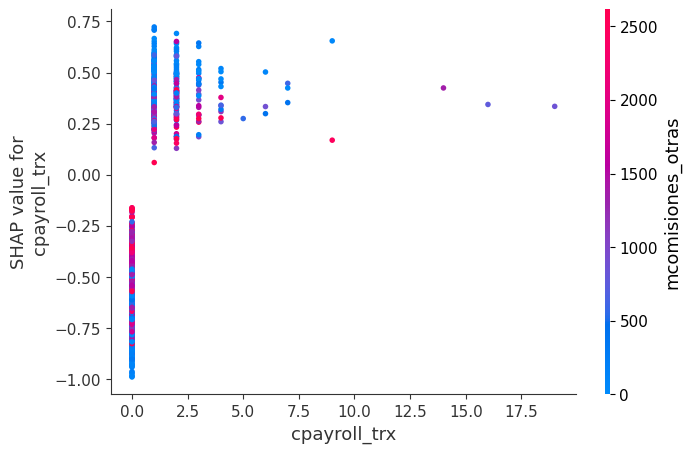

In [41]:
shap.dependence_plot("cpayroll_trx", shap_values[0], Xbajas)

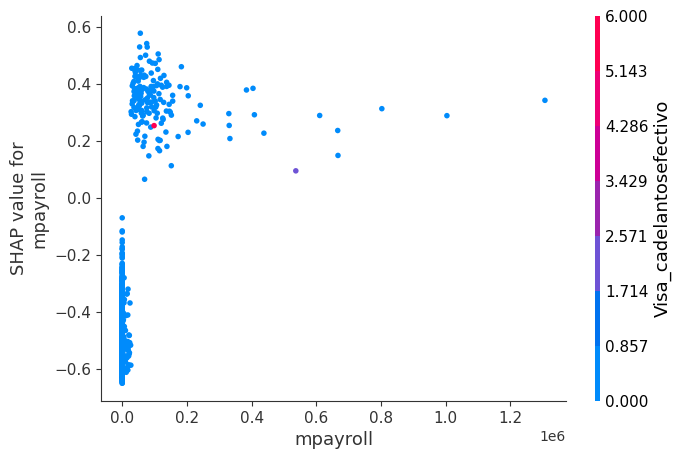

In [39]:
shap.dependence_plot("mpayroll", shap_values[0], Xbajas)

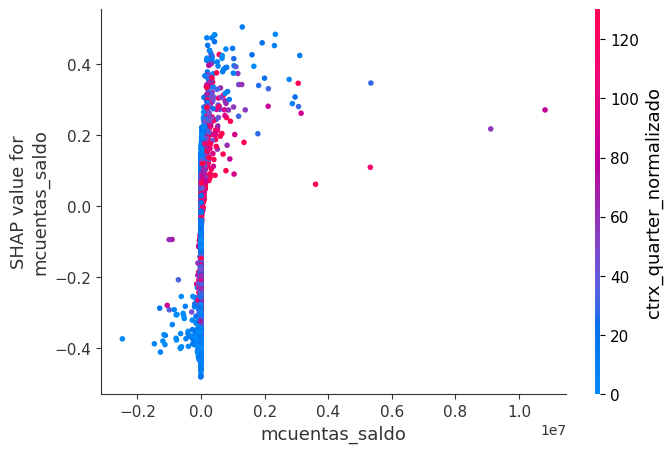

In [42]:
shap.dependence_plot("mcuentas_saldo", shap_values[0], Xbajas)

¿Se podrá hacer una clusterización sobre los valores de shap? 

Como la cantidad de variables es muy alto, es conveniente hacer un embedding con **UMAP**. Como la estrutura de los **shap values** se pueden hacer sin mucho preprocesamiento.

In [45]:
from umap import UMAP
import matplotlib.pyplot as plt


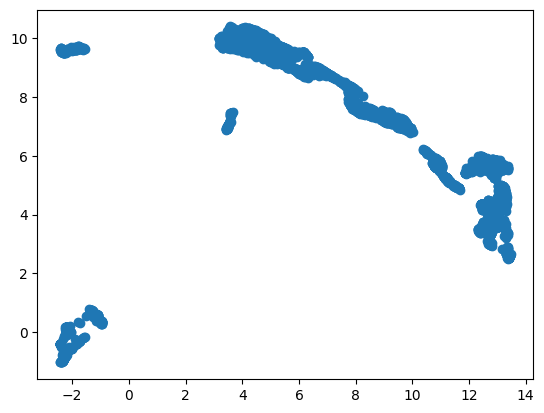

In [46]:
embedding_2d = UMAP(
  n_components=10, n_neighbors=40
).fit_transform(shap_values[0])
plt.scatter(embedding_2d[:,0], embedding_2d[:,1])

In [47]:
embedding_2d = pd.DataFrame(embedding_2d)

In [48]:
embedding_2d = embedding_2d.add_prefix('umap_')

In [49]:
embedding_2d

,umap_0,umap_1,umap_2,umap_3,umap_4,umap_5,umap_6,umap_7,umap_8,umap_9
0,9.649737,7.031214,2.761278,3.387942,8.516005,5.182007,2.589609,4.837702,3.111251,6.418974
1,3.505187,7.016733,-0.058501,4.024606,5.491277,5.940063,5.538953,5.172274,3.444178,6.143764
2,12.955148,3.921677,7.638208,4.934724,9.121819,6.267033,4.035288,4.794556,4.773141,4.839656
3,7.707938,8.396831,0.888636,4.081747,8.313007,5.445751,2.593573,4.079258,1.996272,7.144195
4,12.479687,3.702235,7.772011,4.393657,8.897975,6.600165,3.036379,6.295352,4.630819,4.947227
...,...,...,...,...,...,...,...,...,...,...
6552,8.966016,7.262888,1.958768,2.250094,7.628547,5.030616,1.640850,4.505032,2.409015,6.844461
6553,13.118516,4.865798,8.670959,4.200475,9.057241,7.502673,1.893331,5.571719,5.315586,4.296448
6554,5.896907,9.396469,-0.853541,4.129085,8.117702,5.370377,3.698215,4.411138,2.306310,6.937518
6555,9.735761,6.946794,2.319331,2.014726,7.473481,4.941990,1.138242,4.485795,2.182643,7.061957


In [78]:
Xbajas.filter(regex='.payroll.',axis=1)

,cpayroll_trx,mpayroll2,cpayroll2_trx,mpayroll_sobre_edad,cpayroll_trx_tend6,mpayroll_tend6,mpayroll2_tend6,cpayroll2_trx_tend6,mpayroll_sobre_edad_tend6
5,0,0.0,0,0.000000,0.0,0.0,0.0,0.0,0.0
9,0,0.0,0,0.000000,0.0,0.0,0.0,0.0,0.0
14,0,0.0,0,0.000000,0.0,0.0,0.0,0.0,0.0
20,0,0.0,0,0.000000,0.0,0.0,0.0,0.0,0.0
27,0,0.0,0,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
342981,0,0.0,0,0.000000,0.0,0.0,0.0,0.0,0.0
343190,0,0.0,0,0.000000,0.0,0.0,0.0,0.0,0.0
343432,0,0.0,0,0.000000,0.0,0.0,0.0,0.0,0.0
343571,0,0.0,0,0.000000,0.0,0.0,0.0,0.0,0.0


In [50]:
Xbajas_umap = pd.concat([Xbajas.reset_index(),embedding_2d.reset_index()],axis=1)

In [51]:
Xbajas_umap

,index,numero_de_cliente,foto_mes,active_quarter,cliente_vip,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,mcomisiones,...,umap_0,umap_1,umap_2,umap_3,umap_4,umap_5,umap_6,umap_7,umap_8,umap_9
0,5,31526085,202007,1,0,84,314,2102.692699,64179.803649,1936.345980,...,9.649737,7.031214,2.761278,3.387942,8.516005,5.182007,2.589609,4.837702,3.111251,6.418974
1,9,31680584,202007,1,0,61,314,2628.804398,56895.571426,0.000000,...,3.505187,7.016733,-0.058501,4.024606,5.491277,5.940063,5.538953,5.172274,3.444178,6.143764
2,14,31967484,202007,0,0,72,312,64.468855,15670.983607,8.185779,...,12.955148,3.921677,7.638208,4.934724,9.121819,6.267033,4.035288,4.794556,4.773141,4.839656
3,20,32201581,202007,1,0,60,153,530.882838,646.091828,127.721538,...,7.707938,8.396831,0.888636,4.081747,8.313007,5.445751,2.593573,4.079258,1.996272,7.144195
4,27,32613637,202007,1,0,53,167,-693.733061,-8792.812789,73.239333,...,12.479687,3.702235,7.772011,4.393657,8.897975,6.600165,3.036379,6.295352,4.630819,4.947227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6552,342981,208266612,202105,1,0,46,8,-4518.424285,-10672.594029,0.000000,...,8.966016,7.262888,1.958768,2.250094,7.628547,5.030616,1.640850,4.505032,2.409015,6.844461
6553,343190,209952469,202105,0,0,73,6,127.409030,1279.437523,0.000000,...,13.118516,4.865798,8.670959,4.200475,9.057241,7.502673,1.893331,5.571719,5.315586,4.296448
6554,343432,212188655,202105,1,0,31,3,126.030966,674.079591,59.091714,...,5.896907,9.396469,-0.853541,4.129085,8.117702,5.370377,3.698215,4.411138,2.306310,6.937518
6555,343571,212659672,202105,0,0,66,2,0.000000,0.000000,0.000000,...,9.735761,6.946794,2.319331,2.014726,7.473481,4.941990,1.138242,4.485795,2.182643,7.061957


Su momento de brillar: Qué se puede hacer desde este punto para tratar de interpretar los distintos segmentos para la presentación de Miranda.

In [51]:
Xbajas_umap.head(1)

,numero_de_cliente,foto_mes,active_quarter,cliente_vip,internet,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,mcomisiones,...,Visa_mpagado,Visa_mpagospesos,Visa_mpagosdolares,Visa_fechaalta,Visa_mconsumototal,Visa_cconsumos,Visa_cadelantosefectivo,Visa_mpagominimo,umap_0,umap_1
26,31127916.0,202101.0,1.0,0.0,0.0,42.0,277.0,2649.44,30930.84,2519.56,...,3485.96,-3448.72,0.0,5103.0,3002.88,2.0,0.0,598.23,-5.17834,-1.291859


In [43]:
from sklearn.cluster import DBSCAN

In [45]:
Xbajas_umap.filter(regex='^umap_',axis=1)['umap_0'].shape

(3013,)

In [57]:
labels = DBSCAN(eps=3.5).fit_predict(Xbajas_umap.filter(regex='^umap_',axis=1))
pd.Series(labels).value_counts()

0    5209
1     684
3     391
2     273
dtype: int64

In [58]:
Xbajas_umap['cluster'] = labels

In [95]:
import seaborn as sns


In [123]:
cols

['index',
 'numero_de_cliente',
 'foto_mes',
 'active_quarter',
 'cliente_vip',
 'cliente_edad',
 'cliente_antiguedad',
 'mrentabilidad',
 'mrentabilidad_annual',
 'mcomisiones',
 'mactivos_margen',
 'mpasivos_margen',
 'cproductos',
 'tcuentas',
 'ccuenta_corriente',
 'mcuenta_corriente_adicional',
 'mcuenta_corriente',
 'ccaja_ahorro',
 'mcaja_ahorro',
 'mcaja_ahorro_adicional',
 'mcaja_ahorro_dolares',
 'cdescubierto_preacordado',
 'mcuentas_saldo',
 'ctarjeta_debito',
 'ctarjeta_debito_transacciones',
 'mautoservicio',
 'ctarjeta_visa',
 'ctarjeta_visa_transacciones',
 'mtarjeta_visa_consumo',
 'ctarjeta_master',
 'ctarjeta_master_transacciones',
 'mtarjeta_master_consumo',
 'cprestamos_personales',
 'mprestamos_personales',
 'cprestamos_prendarios',
 'mprestamos_prendarios',
 'cprestamos_hipotecarios',
 'mprestamos_hipotecarios',
 'cplazo_fijo',
 'mplazo_fijo_dolares',
 'mplazo_fijo_pesos',
 'cinversion1',
 'minversion1_pesos',
 'minversion1_dolares',
 'cinversion2',
 'minversion2

In [113]:

cols = [col for col in Xbajas_umap.columns if Xbajas_umap[col].isna().all().sum() == 0]
    
        

In [126]:
Xbajas_umap_pair = Xbajas_umap
Xbajas_umap_pair['cluster'] = Xbajas_umap_pair.cluster.apply(lambda x: str(x))

In [130]:
Xbajas_umap_pair.cluster.describe()

count     6557
unique       4
top          0
freq      5209
Name: cluster, dtype: object

In [138]:
cols

['index',
 'numero_de_cliente',
 'foto_mes',
 'active_quarter',
 'cliente_vip',
 'cliente_edad',
 'cliente_antiguedad',
 'mrentabilidad',
 'mrentabilidad_annual',
 'mcomisiones',
 'mactivos_margen',
 'mpasivos_margen',
 'cproductos',
 'tcuentas',
 'ccuenta_corriente',
 'mcuenta_corriente_adicional',
 'mcuenta_corriente',
 'ccaja_ahorro',
 'mcaja_ahorro',
 'mcaja_ahorro_adicional',
 'mcaja_ahorro_dolares',
 'cdescubierto_preacordado',
 'mcuentas_saldo',
 'ctarjeta_debito',
 'ctarjeta_debito_transacciones',
 'mautoservicio',
 'ctarjeta_visa',
 'ctarjeta_visa_transacciones',
 'mtarjeta_visa_consumo',
 'ctarjeta_master',
 'ctarjeta_master_transacciones',
 'mtarjeta_master_consumo',
 'cprestamos_personales',
 'mprestamos_personales',
 'cprestamos_prendarios',
 'mprestamos_prendarios',
 'cprestamos_hipotecarios',
 'mprestamos_hipotecarios',
 'cplazo_fijo',
 'mplazo_fijo_dolares',
 'mplazo_fijo_pesos',
 'cinversion1',
 'minversion1_pesos',
 'minversion1_dolares',
 'cinversion2',
 'minversion2

In [139]:
Xbajas_umap_pair[['cliente_edad','cliente_antiguedad','mrentabilidad','cpayroll_trx']]

,cliente_edad,cliente_antiguedad,mrentabilidad,cpayroll_trx
0,84,314,2102.692699,0
1,61,314,2628.804398,0
2,72,312,64.468855,0
3,60,153,530.882838,0
4,53,167,-693.733061,0
...,...,...,...,...
6552,46,8,-4518.424285,0
6553,73,6,127.409030,0
6554,31,3,126.030966,0
6555,66,2,0.000000,0


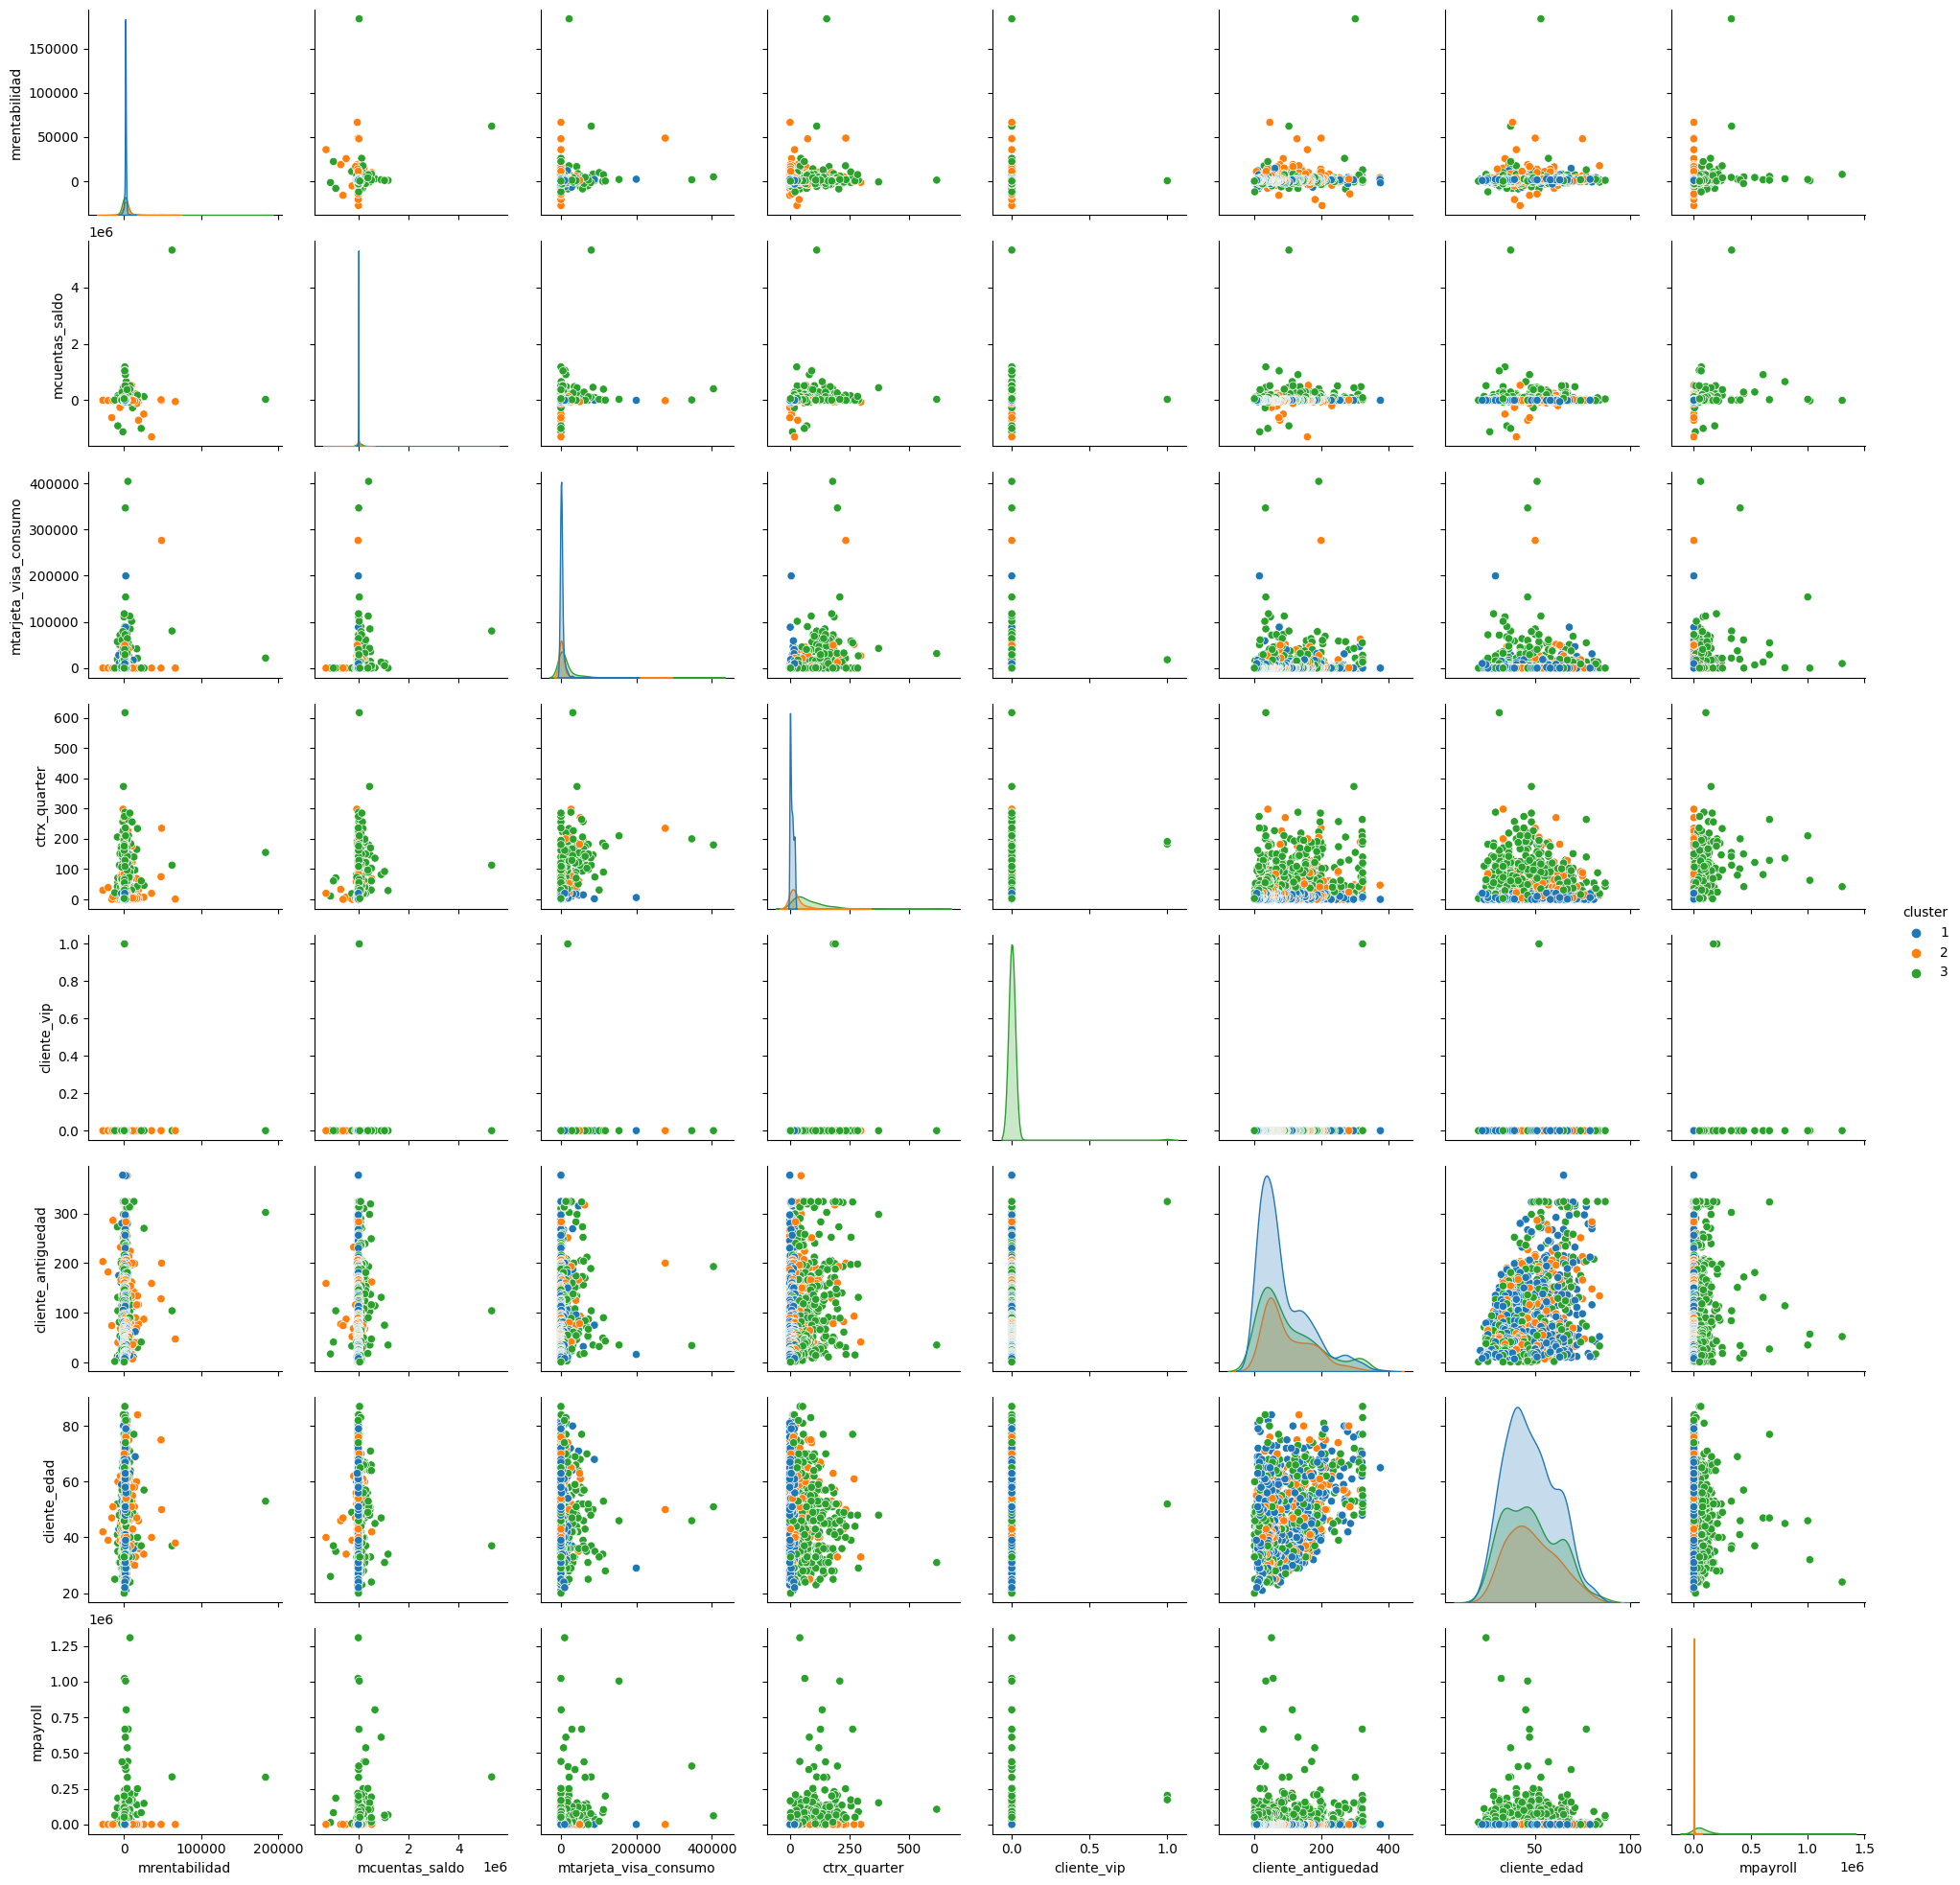

In [142]:
sns.pairplot(Xbajas_umap_pair.loc[Xbajas_umap_pair['cluster']!='0'][['mrentabilidad', 'mcuentas_saldo', 'mtarjeta_visa_consumo', 'ctrx_quarter', 'cliente_vip', 'cliente_antiguedad', 'cliente_edad', 'mpayroll','cluster']],hue='cluster')

In [120]:
g = sns.PairGrid(Xbajas_umap.all())
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

KeyError: True

In [59]:
from math import pi
from sklearn.preprocessing import StandardScaler


In [60]:
scaler = StandardScaler()

In [85]:
Xbajas_umap.groupby('cluster').aggregate({'cpayroll_trx':np.mean})

,cpayroll_trx
cluster,
0,0.001728
1,0.000000
2,0.025641
3,1.728900


In [91]:
Xbajas_umap.groupby('cluster').aggregate({'cpayroll_trx':np.max})

,cpayroll_trx
cluster,
0,4
1,0
2,2
3,19


In [89]:
Xbajas_umap.groupby('cluster').aggregate({'cpayroll_trx_tend6':np.min})

,cpayroll_trx_tend6
cluster,
0,-2.257143
1,-0.571429
2,-1.114286
3,-1.542857


In [79]:
categories = ['ctrx_quarter_normalizado','cpayroll_trx','cpayroll_trx_tend6','mtarjeta_visa_consumo','mcuentas_saldo','mprestamos_personales']
Xbajas_umap_cats = Xbajas_umap[categories+['cluster']]

In [80]:
Xbajas_umap_cats[categories] = scaler.fit_transform(Xbajas_umap_cats[categories])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


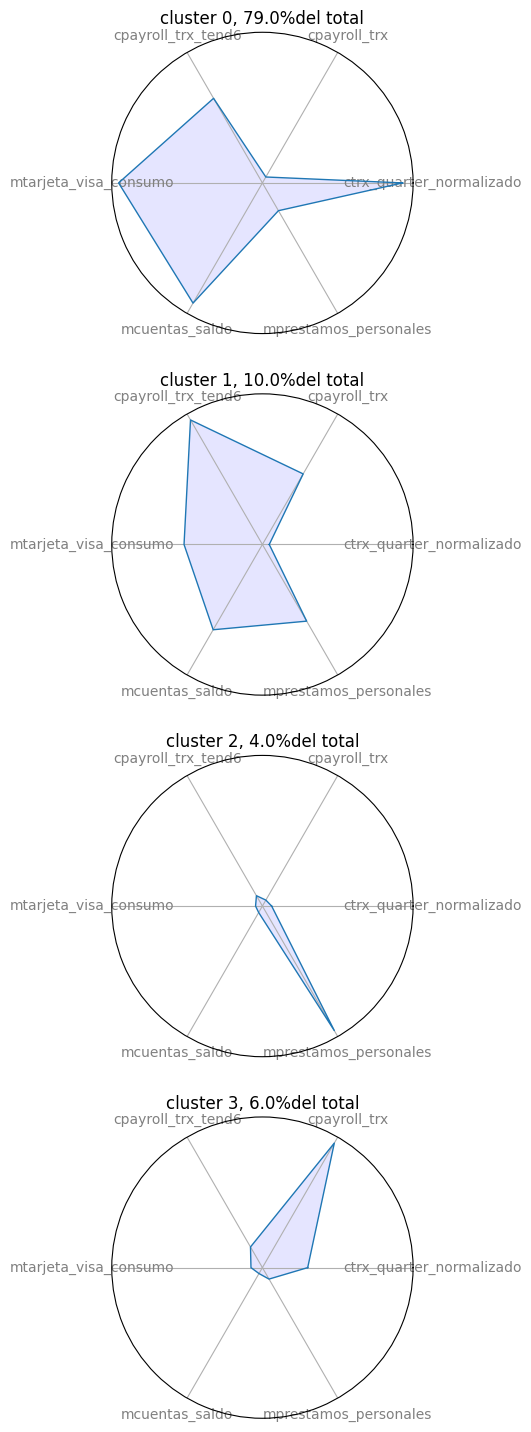

In [81]:

N = len(categories)

fig = plt.figure(figsize=(18,18))


#for i,j,cl in zip([0,0,1,1],[0,1,0,1],range(4)):
for i,cl in zip([411,412,413,414],range(4)):
    ax = fig.add_subplot(i, polar=True)
    values = Xbajas_umap_cats[categories].loc[Xbajas_umap_cats['cluster']==cl].aggregate(np.mean).values.flatten().tolist()
    values += values[:1]
    values

    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    #categories = ['ctrx_quarter','cpayroll_trx','mtarjeta_visa_consumo','mcuentas_saldo','mprestamos_personales','mpasivos_margen']
    #categories_relabeled = ['movimientos_trimestre', 'acred_haberes','consumos_tarjeta','saldo_en_cuentas','deuda_prestamos_personales','margen_por_pasivos']
    plt.xticks(angles[:-1], categories, color='grey', size=10)
    
    # Draw one axe per variable + add labels
    
    
    # Draw ylabels
    #ax.set_theta_offset(pi)
    prop = str(round(Xbajas_umap_cats.loc[Xbajas_umap_cats['cluster']==cl].shape[0]/Xbajas_umap_cats.shape[0] * 100,0))+'%'
    ax.set_title('cluster '+ str(cl) + ', '+ prop + 'del total')
    #ax.annotate(str(round(Xbajas_umap_cats.loc[Xbajas_umap_cats['cluster']==cl].shape[0]/Xbajas_umap_cats.shape[0] * 100,0))+'%',xy=(0.5,0.1),xycoords = 'subfigure fraction')

    plt.yticks([], [], color="grey", size=7)
    #plt.ylim(0,40)
    
    # Plot data
    ax.plot(angles, values, linewidth=1, linestyle='solid')
    
    # Fill area
    ax.fill(angles, values, 'b', alpha=0.1)

    # Show the graph
plt.show()

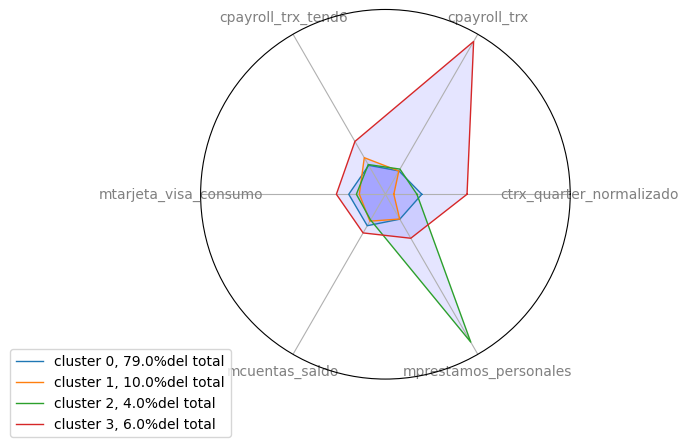

In [93]:
N = len(categories)

#fig = plt.figure(figsize=(18,18))
ax = plt.subplot(111, polar=True)
plt.xticks(angles[:-1], categories, color='grey', size=10)
plt.yticks([], [], color="grey", size=7)
#for i,j,cl in zip([0,0,1,1],[0,1,0,1],range(4)):
for cl in range(4):
    values = Xbajas_umap_cats[categories].loc[Xbajas_umap_cats['cluster']==cl].aggregate(np.mean).values.flatten().tolist()
    values += values[:1]
    values

    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    #categories = ['ctrx_quarter','cpayroll_trx','mtarjeta_visa_consumo','mcuentas_saldo','mprestamos_personales','mpasivos_margen']
    #categories_relabeled = ['movimientos_trimestre', 'acred_haberes','consumos_tarjeta','saldo_en_cuentas','deuda_prestamos_personales','margen_por_pasivos']
    
    
    # Draw one axe per variable + add labels
    
    
    # Draw ylabels
    #ax.set_theta_offset(pi)
    prop = str(round(Xbajas_umap_cats.loc[Xbajas_umap_cats['cluster']==cl].shape[0]/Xbajas_umap_cats.shape[0] * 100,0))+'%'
    label = 'cluster '+ str(cl) + ', '+ prop + 'del total'
    #ax.set_title('cluster '+ str(cl) + ', '+ prop + 'del total')
    #ax.annotate(str(round(Xbajas_umap_cats.loc[Xbajas_umap_cats['cluster']==cl].shape[0]/Xbajas_umap_cats.shape[0] * 100,0))+'%',xy=(0.5,0.1),xycoords = 'subfigure fraction')

    
    #plt.ylim(0,40)
    
    # Plot data
    ax.plot(angles, values, linewidth=1, linestyle='solid',label=label)
    
    # Fill area
    ax.fill(angles, values, 'b', alpha=0.1)

plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

    # Show the graph
plt.show()